# 3D Volume to Volume GAN

In [1]:
%matplotlib inline

import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from skimage.transform import resize
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../scripts')

import pix3pix as p3p
import helper as hp
import data_loader3D as dl
import deconvolution as deconv

sys.path.insert(0, '../scripts/NanoImagingPack')
from microscopy import PSF3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import warnings
warnings.filterwarnings("ignore")

## look for the data

In [6]:
dataset_name = 'NESb'
path = glob('../data/3D/{0}/*'.format(dataset_name))
path = [item for item in path if not item.endswith('.txt')]

dl.print_volume_dimension(path)

dimensions of volumes:
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)


## create TFRecord file

In [7]:
vol_dim = (128, 128, 9)

data_loader = dl.DataLoader3D(dataset_name='NESb', vol_resize=vol_dim)
filename = '../data/TFRecords/{0}_train.tfrecords'.format(dataset_name)

# data_loader.writeTFRecord(filename)

## test the 3D psf for a random volume

In [8]:
path = '../data/3D/NESb/NESb_C2_TP1.tiff'
vol = io.imread(path)
vol = hp.swapAxes(vol, swap=True)
vol = resize(image=vol, output_shape=vol_dim)
print('image after resize in x/y dimension:', vol.shape)

# compute OTF
start_otf = time.time()
otf = PSF3D(im=vol.shape, ret_val = 'OTF')
end_otf = time.time()

# perform convolution on stack with computed otf (with numpy)
start_conv_np = time.time()
vol_otf = deconv.conv3d_fft(vol, otf)
end_conv_np = time.time()

# perform convolution on stack with computed otf (with tensorflow)
# start_conv_tf = time.time()
# vol_otf_tf = deconv.conv3d_fft_tf(vol, otf)
# end_conv_tf = time.time()

# select a random stacks
i = np.random.randint(low=0, high=vol.shape[2], size=1)[0]
print('stack number:\t\t\t', i+1,'/',vol.shape[2])
img = vol[:,:,i]
img_otf = vol_otf[:,:,i]
# img_otf_tf = vol_otf_tf[:,:,i]

print('Time for compute OTF:\t\t', end_otf - start_otf, 's')
print('Time for convolve with numpy:\t', end_conv_np - start_conv_np, 's')
# print('Time for convolve with tensorflow:\t', end_conv_tf - start_conv_tf, 's')

image after resize in x/y dimension: (128, 128, 9)
stack number:			 7 / 9
Time for compute OTF:		 0.04352927207946777 s
Time for convolve with numpy:	 0.027018070220947266 s


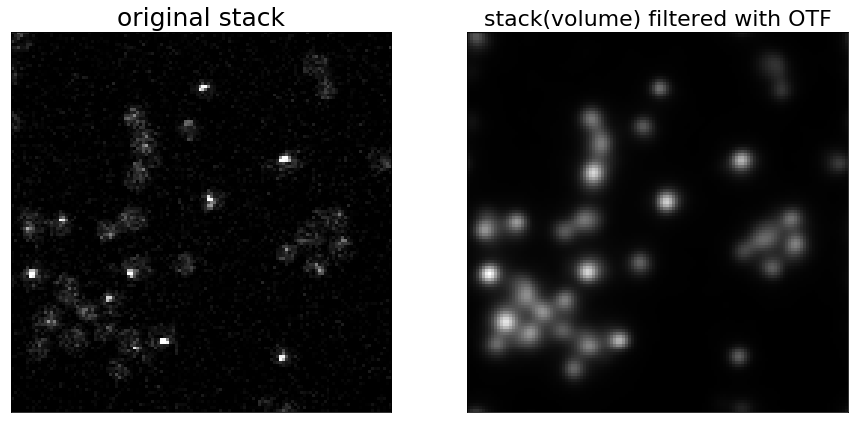

In [9]:
f = plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25)
plt.subplot(122); plt.imshow(img_otf, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
# plt.subplot(133); plt.imshow(img_otf_tf, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.show()

## initialize the volume to volume GAN

In [173]:
volume_resize = vol_dim
directory_name = dataset_name #'NESb'

gan = p3p.Pix3Pix(vol_resize=volume_resize, d_name=directory_name,
                  stack_manipulation=p3p.MANIPULATION.SPATIAL_DOWN)
                  
                 #.SPATIAL_MIN
                 #.SPATIAL_DOWN                  
                 #.SPATIAL_UP
                 #.FREQUENCY_UP
                 #.FREQUENCY_DOWN

discriminator-resize: (?, 128, 128, 8, 1) (?, 128, 128, 8, 1)
discriminator-model in/output:	 (?, 128, 128, 9, 1) (?, 128, 128, 9, 1) 
				 (?, 16, 16, 1, 1)
generator-model input:		 (?, 128, 128, 9, 1)
generator-resize:		 (?, 128, 128, 8, 1)
downsampling:			 (?, 64, 64, 4, 64)
downsampling:			 (?, 32, 32, 2, 128)
downsampling:			 (?, 16, 16, 1, 256)
downsampling:			 (?, 8, 8, 1, 512)
downsampling:			 (?, 4, 4, 1, 512)
upsampling:			 (?, 8, 8, 1, 512)
upsampling:			 (?, 16, 16, 1, 256)
upsampling:			 (?, 32, 32, 2, 128)
upsampling:			 (?, 64, 64, 4, 64)
generator-resize: (?, 128, 128, 8, 1)
generator-model output:		 (?, 128, 128, 9, 1) (?, 128, 128, 9, 1)
finish Pix3Pix __init__


## train volume to volume GAN

In [174]:
epochs = 1

gan.train(epochs=epochs, add_noise=True)

[Epoch 0/0] [Batch 0/9] [D loss: 1.140150, acc:  10%] [G loss: 93.504959] time: 0:00:13.186160
[Epoch 0/0] [Batch 1/9] [D loss: 0.901695, acc:  48%] [G loss: 76.938057] time: 0:00:15.287481
[Epoch 0/0] [Batch 2/9] [D loss: 5.855931, acc:  37%] [G loss: 55.798855] time: 0:00:16.641877
[Epoch 0/0] [Batch 3/9] [D loss: 1.503703, acc:  40%] [G loss: 41.930195] time: 0:00:17.969864
[Epoch 0/0] [Batch 4/9] [D loss: 0.243074, acc:  74%] [G loss: 32.818436] time: 0:00:19.327324
[Epoch 0/0] [Batch 5/9] [D loss: 0.147555, acc:  83%] [G loss: 26.259604] time: 0:00:20.579292
[Epoch 0/0] [Batch 6/9] [D loss: 0.173637, acc:  79%] [G loss: 22.778391] time: 0:00:21.910440
[Epoch 0/0] [Batch 7/9] [D loss: 0.321696, acc:  64%] [G loss: 20.537727] time: 0:00:23.264450
[Epoch 0/0] [Batch 8/9] [D loss: 0.510790, acc:  73%] [G loss: 17.452362] time: 0:00:24.607837

Finish training in (hh:mm:ss.ms) 0:00:24.607837


## release GPU memory

In [116]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

33346

In [119]:
delete_model_memory = False

if delete_model_memory:
    try:
        del gan, discriminator, combined, generator 
    except:
        print('models not available')

## plot random volume with 3 random stacks of GAN

plotted volume: images/NESb\NESb_2018-07-19_15_48_23\0_0.png


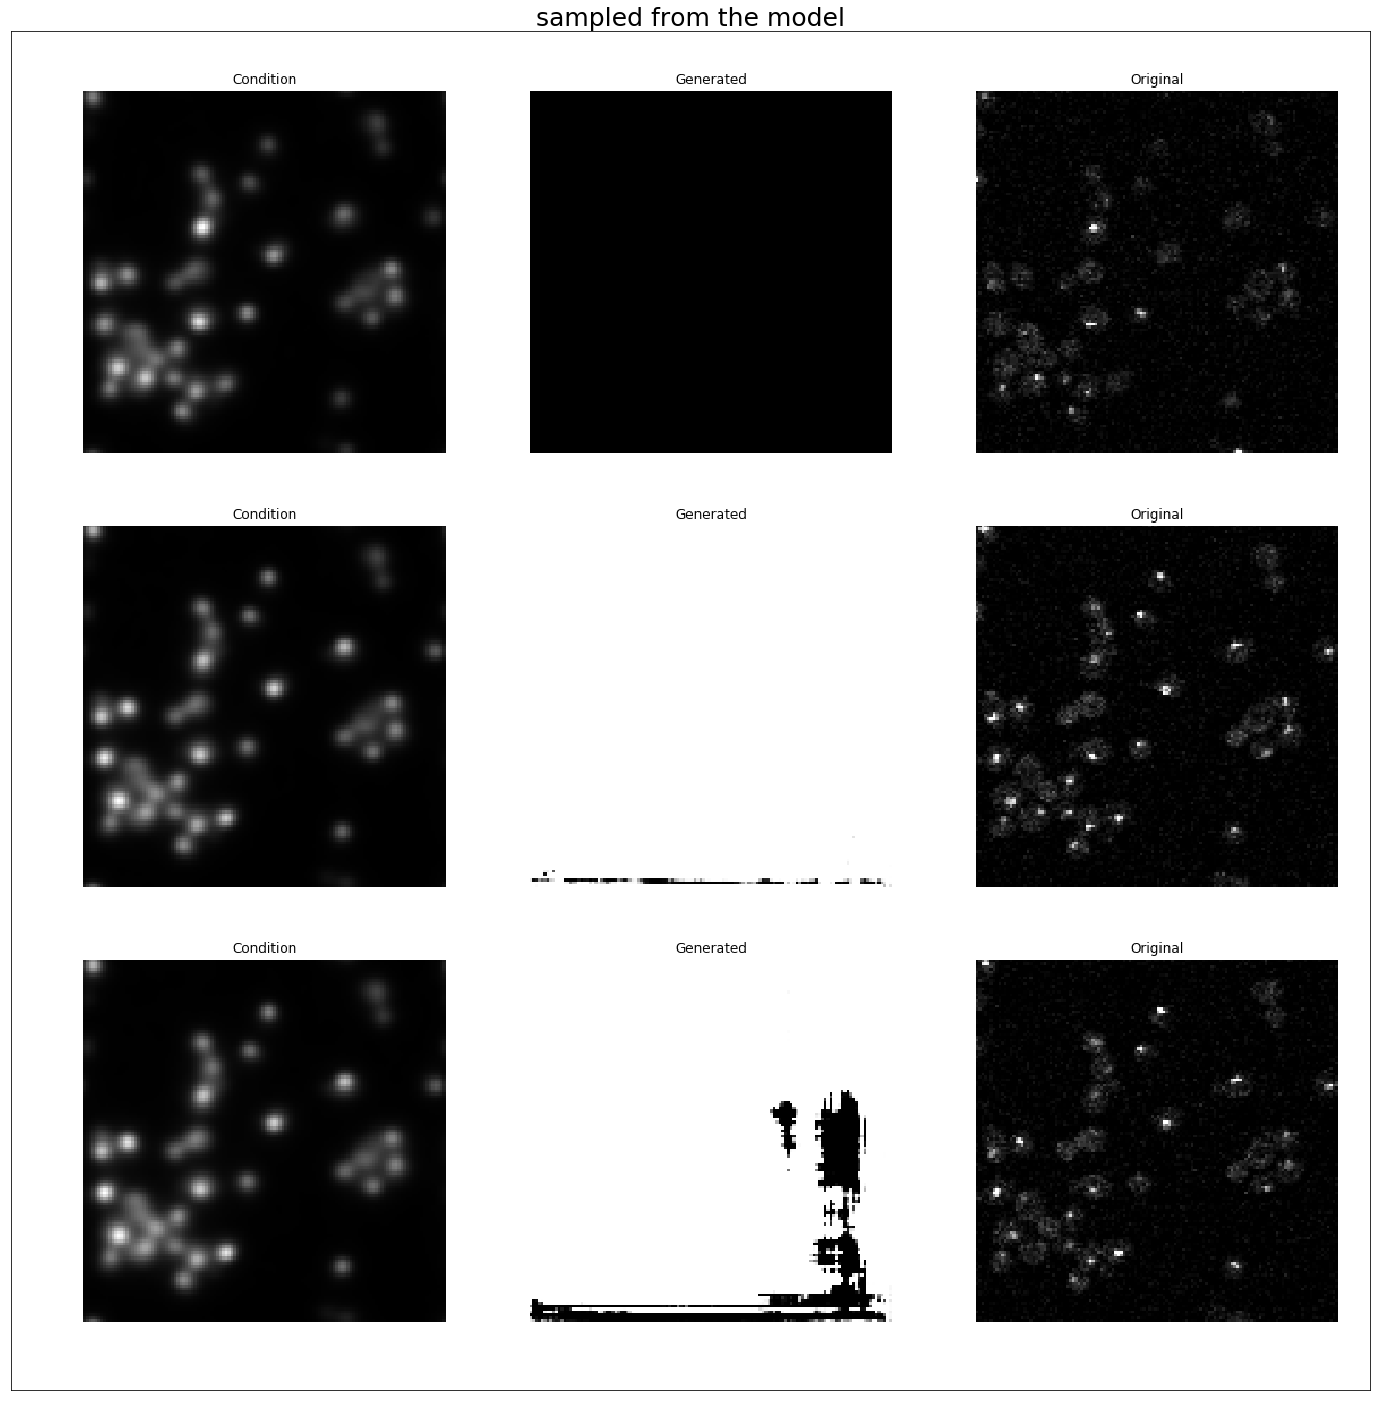

In [122]:
result_path = 'images/{0}/*'.format(dataset_name) 

model_vols = glob(result_path)
selected_folder = model_vols[-1]+'/*'

volumes = glob(selected_folder)
volumes = np.random.choice(volumes, size=1)[0]
vol_plot = io.imread(volumes)
cut = 120; ed = vol_plot.shape[0]
vol_plot = vol_plot[cut:ed-cut, cut:ed-cut , :]

print('plotted volume:', volumes)
f = plt.figure(figsize=(25,25))
plt.imshow(vol_plot); plt.xticks([]); plt.yticks([]); plt.title('sampled from the model', fontsize=25);

## save models, gradients and parameters

In [124]:
save_models = False

if save_models:
    hp.model_saver(model_instance=gan.discriminator, model_name='disc_10%')
    hp.model_saver(model_instance=gan.generator, model_name='gene_10%')
    hp.model_saver(model_instance=gan.combined, model_name='combined_10%')

## create deconvolution model

tf.fft_shift needs even number of dims, so eventually cut an array (then create new otf)

In [153]:
print(vol.shape, otf.shape)
vol_new = vol[:,:,:8]
otf_new = PSF3D(im=vol_new.shape, ret_val = 'OTF')
print(vol_new.shape, otf_new.shape)

(128, 128, 9) (128, 128, 9)
(128, 128, 8) (128, 128, 8)


In [218]:
# otf = PSF3D(im=vol.shape, ret_val = 'OTF')

deconvolution = deconv.Deconvolution(img=vol_new, gan=gan, psf=otf_new)

Tensor("deconvolution_model_in_output_26/x:0", shape=(128, 128, 8), dtype=float32)
<tf.Variable 'deconvolution_model_regularization_21/Variable_1:0' shape=<unknown> dtype=float32_ref>
<tf.Variable 'deconvolution_model_parameter_27/H_x:0' shape=(128, 128, 8) dtype=float32_ref>
<tf.Variable 'deconvolution_model_regularization_21/Variable_2:0' shape=<unknown> dtype=float32_ref>


AttributeError: 'Variable' object has no attribute 'ndim'

## perform deconvolution model

In [215]:
# temp = vol

# print(temp.shape)
# temp = np.expand_dims(temp,axis=0)
# temp = np.expand_dims(temp,axis=-1)

# temp
# print(temp.shape)

gan.discriminator.input_shape #predict(temp)
# deconvolution.optimize(vol_otf)

[(None, 128, 128, 9, 1), (None, 128, 128, 9, 1)]

#  TEST

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant(3.0)
with tf.Session() as sess:
    print(sess.run(a))
        
# I believe that you need to set CUDA_VISIBLE_DEVICES=1. Or which ever GPU you want to use. 
#If you make only one GPU visible, you will refer to it as /gpu:0 regardless of what you set the environment variable to.
#More info on that environment variable: http://www.acceleware.com/blog/cudavisibledevices-masking-gpus

# https://stackoverflow.com/questions/40069883/how-to-set-specific-gpu-in-tensorflow

# if gpu > -1:
#     device = '/gpu:{}'.format(gpu)
# else:
#     device = '/cpu:0'

# with tf.device(device):
#     print('test')

In [49]:
saver = tf.train.Saver(restore_sequentially=True)
saver_def = saver.as_saver_def()

In [170]:
a = np.arange(9).reshape((3, 3))
b = np.arange(9)- 4 
b = b.reshape((3, 3))
mean=0; var = 0.1; sigma = var**0.5
c = deconv.add_gaussian(a) #a + np.random.normal(mean, sigma, a.shape)
print(a,'\n\n', b, '\n\n', c)

[[0 1 2]
 [3 4 5]
 [6 7 8]] 

 [[-4 -3 -2]
 [-1  0  1]
 [ 2  3  4]] 

 [[ 0.06377153 -0.15525078 -0.52228588]
 [-0.09059462 -0.48386826 -0.33711112]
 [-0.37177803  0.29466394 -0.4028283 ]]


In [62]:
print(np.linalg.norm(a-b, ord='fro'))

# frobenius = lambda matrix: np.sqrt(np.sum(matrix ** 2))
frobenius = lambda matrix: np.sqrt(np.sum(np.square(matrix)))
frobenius(a - b)

12.0


12.0

In [ ]:
from keras import losses

losses.kullback_leibler_divergence
losses.mean_squared_error
losses.mean_squared_logarithmic_error
losses.sparse_categorical_crossentropy

tf.image.ResizeMethod.BILINEAR

stack number:			 3 / 8


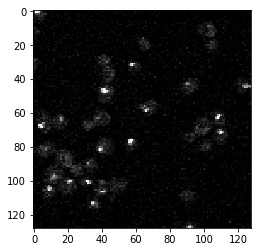

In [152]:
# a = tf.constant(vol_plot)
# b = deconvolution.total_variation(a)

vol_tf = tf.constant(vol_new)
otf_tf = tf.constant(otf_new)

conv = deconv.conv3d_fft_tf(vol=vol_tf, otf=otf_tf)

with tf.Session() as sess:
    vol_conv_tf = sess.run(conv)
    i = np.random.randint(low=0, high=vol_conv_tf.shape[2], size=1)[0]
    print('stack number:\t\t\t', i+1,'/',vol_conv_tf.shape[2])
    img_conv_tf = vol[:,:,i]
        
    plt.imshow(img_conv_tf, cmap='gray')
       
    
# 296215300